In [2]:
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog, local_binary_pattern
from scipy.fftpack import fft2
from scipy.stats import skew, kurtosis, entropy
from skimage.filters import sobel
from skimage.color import rgb2gray
import os
from tqdm import tqdm

def extract_features(image_path):
    if not os.path.exists(image_path):
        print(f"File {image_path} does not exist.")
        return None
    
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image {image_path}.")
        return None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize image
    resized_image = cv2.resize(gray, (128, 128))
    
    # 1. HOG features
    hog_features, _ = hog(resized_image, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
    hog_mean = np.mean(hog_features)
    hog_std = np.std(hog_features)
    
    # 2. FFT features
    fft_features = np.abs(fft2(resized_image))
    fft_mean = np.mean(fft_features)
    fft_std = np.std(fft_features)
    
    # 3. Color histogram (normalized)
    color_hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten()
    color_hist = color_hist / np.sum(color_hist)
    color_hist_mean = np.mean(color_hist)
    color_hist_std = np.std(color_hist)
    
    # 4. Texture features (GLCM - Gray Level Co-occurrence Matrix)
    glcm = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(gray)
    glcm_mean = np.mean(glcm)
    glcm_std = np.std(glcm)
    
    # 5. Local Binary Pattern (LBP)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, lbp.max() + 1), density=True)
    lbp_mean = np.mean(lbp_hist)
    lbp_std = np.std(lbp_hist)
    
    # 6. Edge detection (Sobel)
    edges = sobel(gray)
    edge_mean = np.mean(edges)
    edge_std = np.std(edges)
    
    # 7. Skewness and Kurtosis
    skewness = skew(resized_image, axis=None)
    kurt = kurtosis(resized_image, axis=None)
    
    # 8. Entropy
    ent = entropy(resized_image.flatten())
    
    
    # 10. Image dimensions
    dimensions = np.array(image.shape[:2])
    
    # 11. Mean and Standard Deviation of pixel values
    mean_val = np.mean(resized_image)
    std_val = np.std(resized_image)
    
    # 12. Median of pixel values
    median_val = np.median(resized_image)
    
    # Combine features into a single feature vector
    features = np.array([
        hog_mean, hog_std, 
        fft_mean, fft_std, 
        color_hist_mean, color_hist_std, 
        glcm_mean, glcm_std, 
        lbp_mean, lbp_std, 
        edge_mean, edge_std, 
        skewness, kurt, 
        ent, 
        prnu, 
        dimensions[0], dimensions[1], 
        mean_val, std_val, 
        median_val
    ])
    
    return features

# Prepare dataset
def prepare_dataset(ai_folder, natural_folder):
    feature_list = []
    labels = []

    # Process AI-generated images
    for filename in tqdm(os.listdir(ai_folder)):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(ai_folder, filename)
            features = extract_features(image_path)
            if features is not None:
                feature_list.append(features)
                labels.append(1)  # Label for AI-generated images
    
    # Process natural images
    for filename in tqdm(os.listdir(natural_folder)):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(natural_folder, filename)
            features = extract_features(image_path)
            if features is not None:
                feature_list.append(features)
                labels.append(0)  # Label for natural images

    return feature_list, labels

# Paths to the folders
ai_folder = 'ai_images'  # Path to AI-generated images folder
natural_folder = 'natural_images'  # Path to natural images folder

# Extract features and labels
features, labels = prepare_dataset(ai_folder, natural_folder)

# Convert to DataFrame if features were extracted
if features:
    df = pd.DataFrame(features, columns=[
        'HOG_Mean', 'HOG_Std', 
        'FFT_Mean', 'FFT_Std', 
        'ColorHist_Mean', 'ColorHist_Std', 
        'GLCM_Mean', 'GLCM_Std', 
        'LBP_Mean', 'LBP_Std', 
        'Edge_Mean', 'Edge_Std', 
        'Skewness', 'Kurtosis', 
        'Entropy', 
        'PRNU', 
        'Dim_Height', 'Dim_Width', 
        'Mean_Val', 'Std_Val', 
        'Median_Val'
    ])
    df['Label'] = labels
    print(df.head())
    # Save to CSV
    df.to_csv('image_features_with_labels.csv', index=False)
else:
    print("No valid features extracted.")


100%|██████████| 111859/111859 [1:17:55<00:00, 23.93it/s]


   HOG_Mean   HOG_Std     FFT_Mean       FFT_Std  ColorHist_Mean  \
0  0.146637  0.079216  3755.777512  12498.616015        0.001953   
1  0.151235  0.070041  3799.922172  20225.287451        0.001953   
2  0.140351  0.089886  2404.330825  15701.940717        0.001953   
3  0.143552  0.084679  2474.556824  10848.866785        0.001953   
4  0.146915  0.078701  3984.231592  10564.802252        0.001953   

   ColorHist_Std   GLCM_Mean   GLCM_Std  LBP_Mean   LBP_Std  ...  Skewness  \
0       0.010817  108.301612  63.150549  0.111111  0.072812  ...  0.990699   
1       0.007439  141.463160  65.977177  0.111111  0.078944  ...  0.029299   
2       0.009427  125.101248  62.004580  0.111111  0.085679  ...  0.140705   
3       0.009822   91.240814  55.186957  0.111111  0.081369  ...  1.422600   
4       0.012084   87.912249  66.161854  0.111111  0.072445  ...  1.365358   

   Kurtosis   Entropy      PRNU  Dim_Height  Dim_Width    Mean_Val    Std_Val  \
0 -0.074356  9.484818  0.793162       859

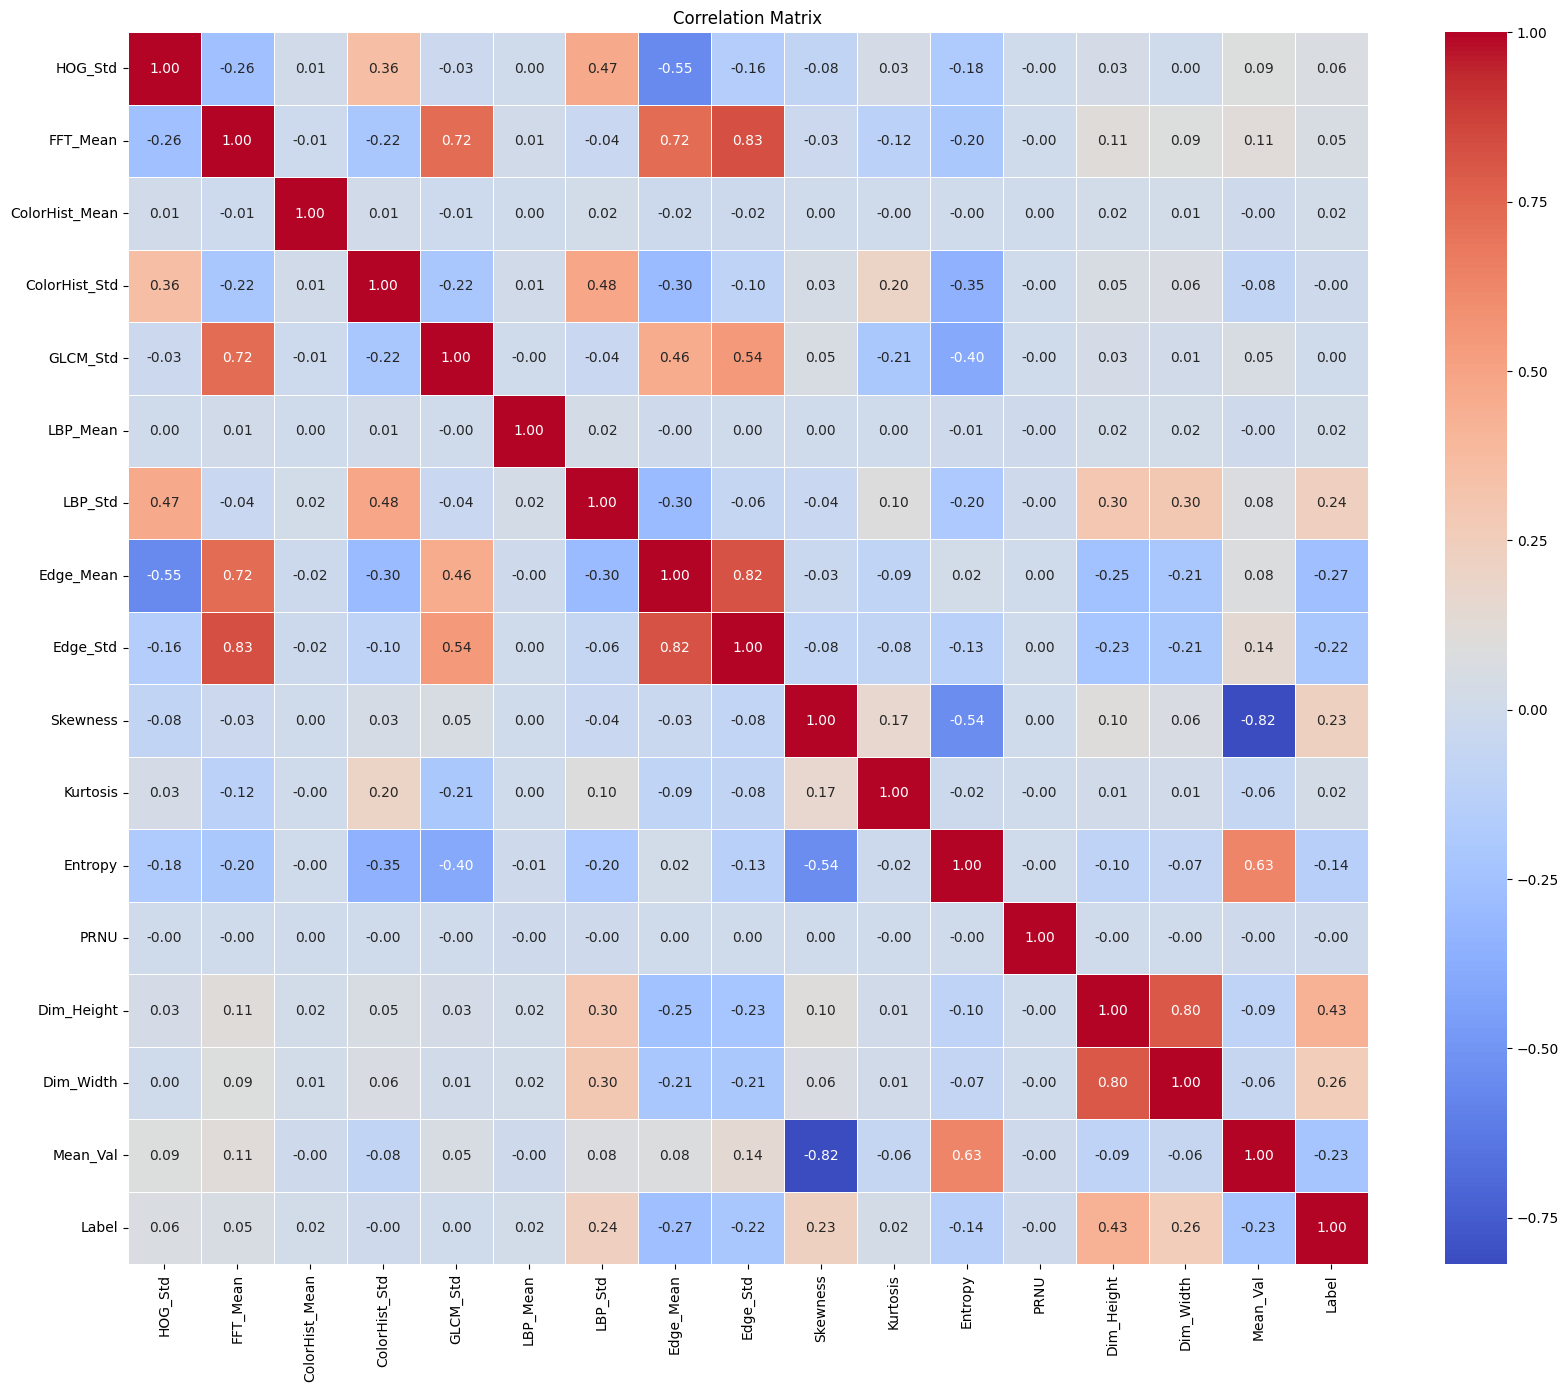

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df=pd.read_csv('image_features_with_labels.csv')
# Load your DataFrame (assuming it's in a CSV file)
df.drop(columns=["GLCM_Mean","HOG_Mean",'Median_Val','FFT_Std','Std_Val'],inplace=True)
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
df=pd.read_csv('image_features_with_labels.csv')
# Load your DataFrame (assuming it's in a CSV file)
df.drop(columns=["GLCM_Mean","HOG_Mean",'Median_Val','FFT_Std','Std_Val'],inplace=True)

# Load your DataFrame (assuming it's in a CSV file)
# Define features and labels
X = df.drop('Label', axis=1)  # Replace 'label' with your actual response variable column name
y = df['Label']  # Replace 'label' with your actual response variable column name

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create XGBoost DMatrix for train and test
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

# Set XGBoost parameters for GPU
params = {
    'objective': 'binary:logistic',
    'device': 'cuda',
    'eval_metric': 'logloss'
}

# Train the model
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

# Make predictions
preds = bst.predict(dtest)
print(np.min(preds))

predictions = [0 if value >= 0.99 else 0 for value in preds]
print(len(predictions))
# Evaluate the accuracy
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy * 100.0:.2f}%')

2.0659198e-07
Accuracy: 4.20%


In [13]:
import os
import cv2
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
from skimage.feature import hog, local_binary_pattern
from skimage.filters import sobel
from scipy.fft import fft2
from scipy.stats import skew, kurtosis, entropy

# Load your DataFrame (assuming it's in a CSV file)
df = pd.read_csv('image_features_with_labels.csv')
df.drop(columns=["GLCM_Mean", "HOG_Mean", 'Median_Val', 'FFT_Std', 'Std_Val','PRNU','Dim_Height','Dim_Width'], inplace=True)

# Define features and labels
X = df.drop('Label', axis=1)
y = df['Label']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create XGBoost DMatrix for train and test
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters for GPU
params = {
    'objective': 'binary:logistic',
    'device': 'cuda',
    'eval_metric': 'logloss'
}

# Train the model
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

# Define the feature extraction function
def extract_features(image_path):
    if not os.path.exists(image_path):
        print(f"File {image_path} does not exist.")
        return None
    
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image {image_path}.")
        return None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize image
    resized_image = cv2.resize(gray, (128, 128))
    
    # 1. HOG features
    hog_features, _ = hog(resized_image, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
    hog_std = np.std(hog_features)
    
    # 2. FFT features
    fft_features = np.abs(fft2(resized_image))
    fft_mean = np.mean(fft_features)
    
    # 3. Color histogram (normalized)
    color_hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten()
    color_hist = color_hist / np.sum(color_hist)
    color_hist_mean = np.mean(color_hist)
    color_hist_std = np.std(color_hist)
    
    # 4. Texture features (GLCM - Gray Level Co-occurrence Matrix)
    glcm = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(gray)
    glcm_std = np.std(glcm)
    
    # 5. Local Binary Pattern (LBP)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, lbp.max() + 1), density=True)
    lbp_mean = np.mean(lbp_hist)
    lbp_std = np.std(lbp_hist)
    
    # 6. Edge detection (Sobel)
    edges = sobel(gray)
    edge_mean = np.mean(edges)
    edge_std = np.std(edges)
    
    # 7. Skewness and Kurtosis
    skewness = skew(resized_image, axis=None)
    kurt = kurtosis(resized_image, axis=None)
    
    # 8. Entropy
    ent = entropy(resized_image.flatten())
    
    
    
    # 11. Mean and Standard Deviation of pixel values
    mean_val = np.mean(resized_image)
    
    # Combine features into a single feature vector
    features = np.array([
        hog_std, 
        fft_mean, 
        color_hist_mean, color_hist_std, 
        glcm_std, 
        lbp_mean, lbp_std, 
        edge_mean, edge_std, 
        skewness, kurt, 
        ent, 
        mean_val
    ])
    
    return features

# Function to iterate over images and predict
def predict_images(model, folder_path, feature_names):
    correct_predictions = 0
    total_images = 0
    
    predictions=[]
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg')):
                image_path = os.path.join(root, file)
                features = extract_features(image_path)
                if features is not None:
                    dmatrix = xgb.DMatrix([features], feature_names=feature_names)
                    prediction = model.predict(dmatrix)
                    predictions.append(prediction)

    return predictions

# Feature names matching the training data
feature_names = [
    'HOG_Std', 'FFT_Mean', 'ColorHist_Mean', 'ColorHist_Std', 'GLCM_Std', 
    'LBP_Mean', 'LBP_Std', 'Edge_Mean', 'Edge_Std', 'Skewness', 'Kurtosis', 
    'Entropy', 'Mean_Val'
]

# Predict on test_images_ai and test_images_natural
accuracy_natural = predict_images(bst, 'test_images_natural', feature_names)

accuracy_ai = predict_images(bst, 'test_images_ai', feature_names)

print( accuracy_natural)
print( accuracy_ai)


[array([0.88533825], dtype=float32), array([0.9973869], dtype=float32), array([0.8092623], dtype=float32), array([0.0925945], dtype=float32)]
[array([0.94836336], dtype=float32), array([0.9845145], dtype=float32), array([0.94407845], dtype=float32), array([0.9536261], dtype=float32), array([0.9868733], dtype=float32), array([0.94105756], dtype=float32)]
